In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
if sys.path[-1] != "..": sys.path.append("..")
import model
from common import cosmology, rh_neutrino, constants, constraints, util

In [3]:
f_a = 1e10
chi0 = 1e9
m_chi = 100 # this should be irrelevant
m_a = constraints.minimal_axion_mass_from_decay(f_a) 
H_inf = max(constraints.calc_H_inf_max(f_a), constraints.calc_H_inf_max(chi0))
Gamma_phi = H_inf
g = 1e-3
Gamma_a = 5e2 # this is fake
assert m_chi < H_inf
assert m_a < H_inf
%time sol = model.simulate(m_a, f_a, Gamma_phi, H_inf, chi0, m_chi, g, rtol=1e-5) # , solver="RK45")

CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 402 ms


In [4]:
def scalar_pot(field, field_dot, m_field, other, g):
    return 0.5 * field_dot**2 + 0.5 * m_field**2 * field**2 + g * field**2 * other**2

def rhs(t, y, m_a, m_chi, g, Gamma_a):
    a, a_dot, chi, chi_dot, rho_rad, R = y
    rho_a = scalar_pot(a, a_dot, m_a, chi, g)
    rho_chi = scalar_pot(chi, chi_dot, m_chi, a, g)
    H = cosmology.calc_hubble_parameter(rho_a + rho_chi + rho_rad)
    return (
        a_dot,
        - (3 * H + Gamma_a) * a_dot - m_a**2 * a - g * a * chi**2,
        chi_dot,
        - 3 * H * chi_dot - m_chi**2 * chi - g * chi * a**2,
        - 3 * H * rho_rad + Gamma_a * rho_a,
        R * H,
    )
span = 1e3
steps = np.geomspace(sol.t[-1], sol.t[-1] * span, 1000)
initial = (f_a * sol.theta[-1], sol.theta_dot[-1] * f_a, sol.chi[-1], sol.chi_dot[-1], sol.rho_R[-1], 1.0)
%time more_sol = solve_ivp(rhs, (steps[0], steps[-1]), initial, args=(m_a, m_chi, g, Gamma_a), t_eval=steps, rtol=1e-5)

CPU times: user 23.7 s, sys: 11.7 ms, total: 23.7 s
Wall time: 23.7 s


In [5]:
a, a_dot, chi, chi_dot, rho_rad, R = more_sol.y 
rho_a = scalar_pot(a, a_dot, m_a, chi, g)
rho_chi = scalar_pot(chi, chi_dot, m_chi, a, g)
T = cosmology.calc_temperature(rho_a + rho_chi + rho_rad)
t = more_sol.t

(1, 6.920528147031005e+46)

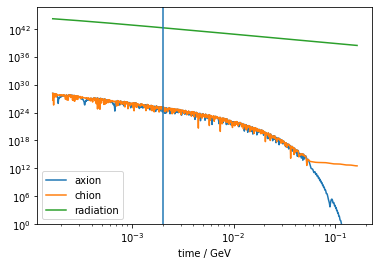

In [6]:
plt.loglog(t, rho_a, label="axion")
plt.loglog(t, rho_chi, label="chion")
plt.loglog(t, rho_rad, label="radiation")
plt.xlabel("time / GeV")
plt.axvline(1 / Gamma_a)
plt.legend()
plt.ylim(1, plt.ylim()[1])

In [19]:
n = 12
rho0 = np.mean(rho_tot[:n]) 
rho_a_0 = np.mean(rho_a[:n])
rho_chi_0 = np.mean(rho_chi[:n])
rho_rad_0 = np.mean(rho_rad[:n])

In [22]:
def rhs_energy(t, y, Gamma_a):
    rho_rad, rho_a, rho_chi = y
    H = cosmology.calc_hubble_parameter(rho_rad + rho_a + rho_chi)
    return (
        - 4 * H * rho_rad + Gamma_a * rho_a,
        - 4 * H * rho_a - Gamma_a * rho_a,
        - 4 * H * rho_chi,
    )
#initial = (sol.rho_R[-1], 
#            scalar_pot(sol.theta[-1] * f_a, sol.theta_dot[-1] * f_a, m_a, sol.chi[-1], g),
#            scalar_pot(sol.chi[-1], sol.chi_dot[-1], m_chi, sol.theta[-1] * f_a, g),
#           )

energy_sol = solve_ivp(rhs_energy, (t[0], t[-1]), (rho_rad_0, rho_a_0, rho_chi_0), args=(Gamma_a,))
rho_tot_sim = energy_sol.y[1] + energy_sol.y[2]

rho0, Gamma_a, t_decay, p
[1.65642717e+28 5.00000000e+02 2.00000000e-03 4.00000000e+00]
[ 7.79336420e+28  3.20621732e+02 -5.11627805e-03  4.14499806e+00]
[9.26482399e+33 2.02152608e+00 3.71472863e+02 2.57610908e-02]


(100000000.0, 6.156858304985864e+30)

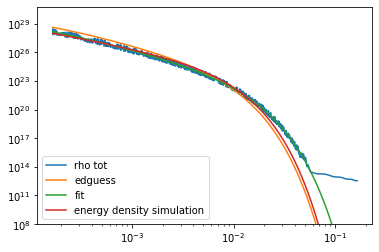

In [23]:
rho_tot = rho_chi + rho_a
R0 = 1
plt.plot(t, rho_tot, label="rho tot")

t_decay = 1 / Gamma_a
model = lambda t, rho0, Gamma_a, t_decay, p: rho0 * (R0 / R[:len(t)])**p * np.exp(- Gamma_a * (t - t_decay))
guess = (rho0, Gamma_a, t_decay, 4)
plt.plot(t, model(t, *guess), label="edguess")

bad = 850
fit_fn = lambda t, *params: np.log(model(t, *params))
params, cov = curve_fit(fit_fn, t[:bad], np.log(rho_tot[:bad]), p0=guess)
print("rho0, Gamma_a, t_decay, p")
print(np.array(guess))
print(params)
print(np.sqrt(np.diag(cov)))
plt.plot(t, model(t, *params), label="fit")

plt.plot(energy_sol.t, energy_sol.y[1], label="energy density simulation")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim(1e8, plt.ylim()[1])

In [119]:
np.polyfit(np.log(t), np.log(R), 1)

array([0.64853274, 5.55009329])

Text(0, 0.5, 'chion $\\chi$ / GeV')

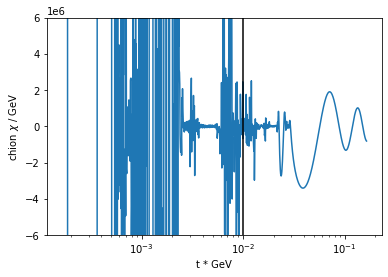

In [87]:
plt.semilogx(t, chi)
plt.ylim(-6e6, 6e6)
plt.xlabel("t * GeV")
plt.axvline(1 / m_chi, color="black")
plt.ylabel(r"chion $\chi$ / GeV")